In [1]:
import numpy as np
import cv2
import os
import sys
from PIL import Image
# import png
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

In [2]:
def plotImage(img, edges = None):
    # plot the image with edges or only image
    if not edges:
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.gray()
        plt.imshow(img)
    else:
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.gray()
        plt.imshow(img)
        plt.plot()
        l = mlines.Line2D([xmin,xmax], [ymin,ymax])

In [3]:
def plotProfile(profile):
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(range(len(profile)), profile)

In [4]:
def imgFiltering(img):
    median = cv2.medianBlur(img, 3)
    return median

In [5]:
def smooth(x, window_len=11, window='hanning'):
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [6]:
def removeCloseGrad(gradients):
    # after thresholding the gradient of the profile, same large edge may create some consecutive large gradients
    nonConsecutiveEdges = [gradients[0]]
    counter = 1
    for gradient in gradients:
        if gradient - nonConsecutiveEdges[-1] == 0:
            pass
        elif gradient - nonConsecutiveEdges[-1] == counter:
            counter += 1
        else:
            nonConsecutiveEdges.append(gradient)
            counter = 1
    # the first one is fake edge created by color filling
    return nonConsecutiveEdges[1:]

In [7]:
def filterAccordingToWidth(gradients):
    # WARNING!!
    # this is a cheating trick, manually measured the tow width -> around 140 pxls
    towWidth = 140
    tows = [gradients[0]]
    for gradient in gradients:
        if (gradient - tows[0])%towWidth < 20 or (gradient - tows[0])%towWidth > 120:
            tows.append(gradient)
    return tows[1:]

In [8]:
# find consecutive zeros
def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

In [9]:
# processing steps from Profactor, first interpolate the black dots
def filterRow(row):
    zeroRanges = zero_runs(row)
    if zeroRanges.size != 0:
        for zeroRange in zeroRanges:
            if zeroRange[0] == 0 and zeroRange[1] != len(row):
                row[zeroRange[0] : zeroRange[1]].fill(row[zeroRange[1]])
            elif zeroRange[0] != 0 and zeroRange[1] == len(row):
                row[zeroRange[0] : zeroRange[1]].fill(row[zeroRange[0]-1])
            elif zeroRange[0] != 0 and zeroRange[1] != len(row):
                x = [zeroRange[0] - 1, zeroRange[1]]
                y = [row[zeroRange[0] - 1], row[zeroRange[1]]]
                row[zeroRange[0] : zeroRange[1]] = np.interp(range(zeroRange[0], zeroRange[1]), x, y)
    else:
        return row
    return row

In [10]:
def printStatus(fileName, img):
#     print('The file name is', fileName, \
#              '\nThe image size', img.shape, \
#              '\nThe whole image mean value:', np.mean(img), \
#              '\nThe maximum value:', np.amax(img), \
#              '\nThe minimum value:', np.amin(img), \
#              '\n\nThe image left part, mean value:', np.mean(img[:, :1000]), \
#              '\nThe image left part, max value:', np.amax(img[:, :1000]), \
#              '\nThe image left part, min value:', np.amin(img[:, :1000]), \
#              '\n\nThe image right part, mean value:', np.mean(img[:, 1000:]), \
#              '\nThe image right part, max value:', np.amax(img[:, 1000:]), \
#              '\nThe image right part, min value:', np.amin(img[:, 1000:]), \
#              '\n-------------------------------------------------------\n')
    print('The file name is', fileName, \
             '\nThe image size', img.shape, \
             '\nThe whole image mean value:', np.mean(img), \
             '\nThe maximum value:', np.amax(img), \
             '\nThe minimum value:', np.amin(img), \
             '\n-------------------------------------------------------\n')

In [11]:
def normalizeImg(img):
    """
    Normalize the image to [0, 255], may not be necessary
    """
    normalizedImg = img - np.amin(img)
    normalizedImg = np.multiply((255.0/normalizedImg.max()), normalizedImg)
    normalizedImg = normalizedImg.astype(int)
    return normalizedImg

In [12]:
def saveImg(fileName, targetDir, img):
    nameDir = targetDir + fileName
    
    # Use pypng to write img as a grayscale PNG.
#     with open(nameDir, 'wb') as f:
#         writer = png.Writer(width=img.shape[1], height=img.shape[0], bitdepth=16, greyscale=True)
#         gray2list = img.tolist()
#         writer.write(f, gray2list)
        
    cv2.imwrite(nameDir, img)

In [13]:
def fitProfileAndPlot(profile):
    # define a function to be fitted
    def func(x, a, b, c):
        return np.square(x)*a + x*b + c 
    
    # plot the fitted function on the profile
    plotProfile(profile)
    popt, pcov = curve_fit(func, range(len(profile)), profile)
    plt.plot(range(len(profile)), func(range(len(profile)), *popt), \
             'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

In [14]:
def fitProfileAndNormalize(profile):
    # define a function to be fitted
    def func(x, a, b, c):
        return np.square(x)*a + x*b + c 
    
    # normalize the profile and avoid negative value
    popt, pcov = curve_fit(func, range(len(profile)), profile)
    [a, b, c] = popt
    minVal = np.amin(profile - func(range(len(profile)), a, b, c)) 
    return profile - func(range(len(profile)), a, b, c) - minVal

In [15]:
def fitProfile(profile):
    # define a function to be fitted
    def func(x, a, b, c):
        return np.square(x)*a + x*b + c 
    
    # normalize the profile and avoid negative value
    popt, pcov = curve_fit(func, range(len(profile)), profile)
    return popt

In [16]:
def interpolationRows(paramsTop, paramsBottom, wTop, wBottom):
    """
    Interpolation of two fixed fitting curves to get a fitting curve at any row in a frame.
    Return the interpolated parameters of a curve.
    """
    return paramsTop*wTop + paramsBottom*wBottom

In [17]:
def colorNormalize(img):
    # scaling factor
    maxPxlValue = img.max()
    minPxlValue = img.min()
    if maxPxlValue == minPxlValue:
        return None
    
    alpha = 255/(maxPxlValue-minPxlValue)

    # shifting factor
    beta = -min(minPxlValue * alpha, maxPxlValue * alpha)
    normalizedImg = np.float32(img) * alpha + beta
    normalizedImg = np.uint8(normalizedImg)
    im_color = cv2.applyColorMap(normalizedImg, cv2.COLORMAP_BONE)
    return normalizedImg

In [26]:
sourceFolder = '/Users/zeekile/Desktop/Infy/nlr_data/20200422_Morning_range/'
# sourceFolder = '/Users/zeekile/Downloads/'
# sourceFolder = '/Users/zeekile/Desktop/Infy/nlr_data/goodRange/'

for fileName in os.listdir(sourceFolder): 
    if fileName.endswith(".png"):
        print(fileName)
        filePath = os.path.join(sourceFolder, fileName)
        img = (cv2.imread(filePath, -1)).astype('int32')
        imgOriginalCopy = np.copy(img)
        imgFilled = np.copy(img)
        # printStatus(fileName, img)
        
        # fill the black holes
        # plotImage(imgOriginalCopy)
        for rowId in range(len(imgFilled)):
            imgFilled[rowId] = filterRow(imgFilled[rowId])
            # imgFilled[rowId] = fitProfileAndNormalize(imgFilled[rowId])
        # plotImage(imgFilled)
        
        # fit two selected profiles, and substract the frame with interpolation
        paramsTop = fitProfile(imgFilled[0])
        paramsMiddle = fitProfile(imgFilled[int(len(imgFilled)/2)])
        paramsBottom = fitProfile(imgFilled[-1])
        x = np.array(range(len(imgFilled[0])))
        for rowId in range(len(imgFilled)):
            if rowId <= int(len(imgFilled)/2):
                wBottom = rowId / int(len(imgFilled)/2)
                wTop = 1 - wBottom
                [a,b,c] = interpolationRows(paramsTop, paramsMiddle, wTop, wBottom)
                imgFilled[rowId] = imgFilled[rowId] - (np.square(x)*a + x*b + c)
            else:
                wBottom = (rowId - int(len(imgFilled)/2)) / (len(imgFilled) - int(len(imgFilled)/2))
                wTop = 1 - wBottom
                [a,b,c] = interpolationRows(paramsMiddle, paramsBottom, wTop, wBottom)
                imgFilled[rowId] = imgFilled[rowId] - (np.square(x)*a + x*b + c)
        minVal = np.amin(imgFilled) 
        imgFilled = imgFilled - minVal
        
        # prune some pure black images
        if ((imgFilled[np.nonzero(imgFilled)]).shape)[0] == 0:
            continue
        minval = np.min(imgFilled[np.nonzero(imgFilled)])
        normalized = (((imgFilled - minval)/(np.max(imgFilled) - minval)) * 255).astype('int')
        # plotImage(normalized)
        
        try:
            saveImg(fileName, '/Volumes/ZEEKANDISK/cv2write/normalized/20200422_Morning_range/', normalized)
        except:
            print("[0]Unexpected error from file:", fileName, sys.exc_info()[0])
            raise
        
        try:
            normalized = np.uint8(normalized)
            im_color = cv2.applyColorMap(normalized, cv2.COLORMAP_BONE)
            cv2.imwrite('/Volumes/ZEEKANDISK/cv2write/colored/20200422_Morning_range/'+fileName, im_color)
        except:
            print("[1]Unexpected error from file:", fileName, sys.exc_info()[0])
            raise

#     break

buffer_2020-04-22-074018.615061742.json_range.png
buffer_2020-04-22-075841.344916367.json_range.png
buffer_2020-04-22-074305.587144261.json_range.png
buffer_2020-04-22-074138.302786622.json_range.png
buffer_2020-04-22-070539.821983643.json_range.png
buffer_2020-04-22-073236.839940719.json_range.png
buffer_2020-04-22-080457.990005081.json_range.png
buffer_2020-04-22-075314.443818671.json_range.png
buffer_2020-04-22-070813.45273709.json_range.png
buffer_2020-04-22-073946.226575468.json_range.png
buffer_2020-04-22-074203.865635505.json_range.png
buffer_2020-04-22-074046.451604292.json_range.png
buffer_2020-04-22-070804.110627260.json_range.png
buffer_2020-04-22-074417.394937339.json_range.png
buffer_2020-04-22-070847.712335909.json_range.png
buffer_2020-04-22-080425.273579847.json_range.png
buffer_2020-04-22-082259.676353035.json_range.png
buffer_2020-04-22-080218.938090347.json_range.png
buffer_2020-04-22-073654.625135436.json_range.png
buffer_2020-04-22-080531.275315375.json_range.png
b

buffer_2020-04-22-080551.342921672.json_range.png
buffer_2020-04-22-082138.468883875.json_range.png
buffer_2020-04-22-073812.921184668.json_range.png
buffer_2020-04-22-080639.105692943.json_range.png
buffer_2020-04-22-075531.131663859.json_range.png
buffer_2020-04-22-073127.174041431.json_range.png
buffer_2020-04-22-073917.257712846.json_range.png
buffer_2020-04-22-071003.479793681.json_range.png
buffer_2020-04-22-080338.438532745.json_range.png
buffer_2020-04-22-080602.828735925.json_range.png
buffer_2020-04-22-073002.237955443.json_range.png
buffer_2020-04-22-074507.241887279.json_range.png
buffer_2020-04-22-080612.717876692.json_range.png
buffer_2020-04-22-082241.702147318.json_range.png
buffer_2020-04-22-075549.949595526.json_range.png
buffer_2020-04-22-080203.434091232.json_range.png
buffer_2020-04-22-073202.320577979.json_range.png
buffer_2020-04-22-075713.612906023.json_range.png
buffer_2020-04-22-075212.224771919.json_range.png
buffer_2020-04-22-070748.548345623.json_range.png


In [39]:
# write out the file names to find out consecutive images
originFolder = '/Volumes/ZEEKANDISK/nlr/original/20200422_afternoon_range/'
selectFolder = '/Volumes/ZEEKANDISK/nlr/selection/20200422_afternoon_range/'
originList = os.listdir(originFolder)
selectList = os.listdir(selectFolder)
originList.sort()
selectList.sort()
originList = originList[int(len(originList)/2):]

for fileName in originList:
    if fileName.endswith(".png"):
        if fileName in selectList:
            print(fileName, '-------------------')
        else:
            print(fileName)

buffer_2020-04-22-122640.489188254.json_range.png
buffer_2020-04-22-122643.674323395.json_range.png -------------------
buffer_2020-04-22-122653.120210515.json_range.png
buffer_2020-04-22-122656.305522128.json_range.png
buffer_2020-04-22-122659.490906810.json_range.png
buffer_2020-04-22-122702.676189588.json_range.png
buffer_2020-04-22-122705.904694395.json_range.png -------------------
buffer_2020-04-22-122709.89958755.json_range.png
buffer_2020-04-22-122715.367120251.json_range.png
buffer_2020-04-22-122718.552439121.json_range.png
buffer_2020-04-22-122721.737816858.json_range.png
buffer_2020-04-22-122724.923038495.json_range.png -------------------
buffer_2020-04-22-122728.266507326.json_range.png
buffer_2020-04-22-122737.506725725.json_range.png
buffer_2020-04-22-122740.692116399.json_range.png
buffer_2020-04-22-122743.877466419.json_range.png
buffer_2020-04-22-122747.62657766.json_range.png -------------------
buffer_2020-04-22-122750.759413260.json_range.png
buffer_2020-04-22-1227

## Tow detection 

In [18]:
import pandas as pd

In [19]:
imgSourceFolders = '/home/mengl/Documents/nlr/consecutive/'
imgTargetFolders = '/home/mengl/Documents/nlr/towed/'
folderList = os.listdir(imgSourceFolders)
folderList.sort()
print(folderList)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11_overflow', '12_jump', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


In [20]:
def fit_edge(gradients):
    # define a function to be fitted
    def func(x, a, b, c):
        return np.square(x)*a + x*b + c 
    
    popt, pcov = curve_fit(func, range(len(gradients)), gradients)
    return popt

In [25]:
def tow_detection(img, num_tow = 8, rigidity=8):
    """
    1. Need to differentiate the curved ones and straight ones.
    2. Separate the cases for different tows
    Inputs:
        num_tow: the number of tows should be detected from the image.
        rigidity: how straight the fitted curve along edges.
    Return:
        edges: [(num_tow+1) x 2 x height]
    """
    # filtering the images
    medianed = cv2.medianBlur(img, 13)
    # plotImage(medianed) 
    _, median_gradient = np.gradient(img) # only the horizontal gradient is needed, on medianed/original image

    # create a mean vertically and find gradient on it
    means = np.mean(medianed, axis=0)

    # find course edges
    gradientArr = np.gradient(means)
    sortInds = np.argsort(np.absolute(gradientArr))
    maxGrdInd = sortInds[-1]
    sortIndsWithoutMax = sortInds[np.where(np.logical_or(sortInds>(maxGrdInd+10), sortInds<(maxGrdInd-10)))]
    secMaxGrdInd = sortIndsWithoutMax[-1]
    print("The course edges are at ", maxGrdInd, secMaxGrdInd)
    
    y = np.arange(len(img), dtype=int) 
    edges = np.empty([num_tow + 1, 2, len(img)])
    
    # finding local maximal gradients
    tow_width = int((max(maxGrdInd, secMaxGrdInd) - min(maxGrdInd, secMaxGrdInd))/num_tow)
    edge_list = [min(maxGrdInd, secMaxGrdInd) + i*tow_width for i in range(num_tow + 1)]
    for i in range(len(edge_list)):
        mid = edge_list[i]
        left = mid - int(tow_width/rigidity)
        right = mid + int(tow_width/rigidity)
        search_range = median_gradient[:, left:right]
        max_gradient = np.argmax(search_range, axis=1) + left
        # print("Max gradient of edge", i, ", its shape is", max_gradient.shape)
        
        [a, b, c] = fit_edge(max_gradient)
        x = range(len(max_gradient))
        fitted_curve = np.square(x)*a + x*b + c
        # print("Fitted curve shape is", fitted_curve.shape)
        
        edges[i] = np.concatenate((fitted_curve[:, None], y[:, None]), axis=0).reshape((2, -1)) 
    return edges

buffer_2020-04-22-122824.601248226.json_range.png
The course edges are at  1107 2250
The edges shape is (9, 2, 512)


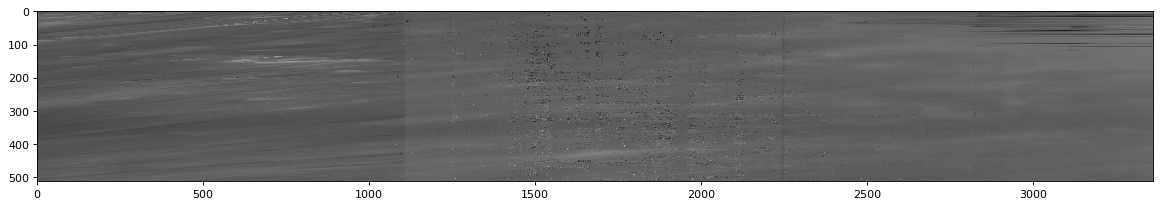

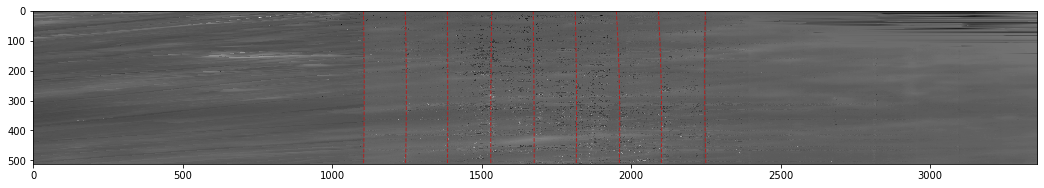

buffer_2020-04-22-122827.786457642.json_range.png
The course edges are at  1106 2249
The edges shape is (9, 2, 512)


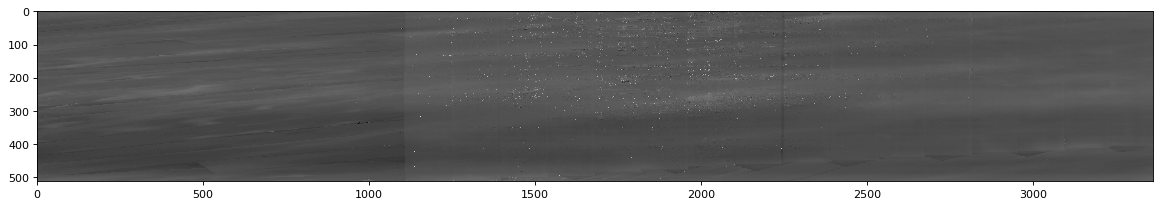

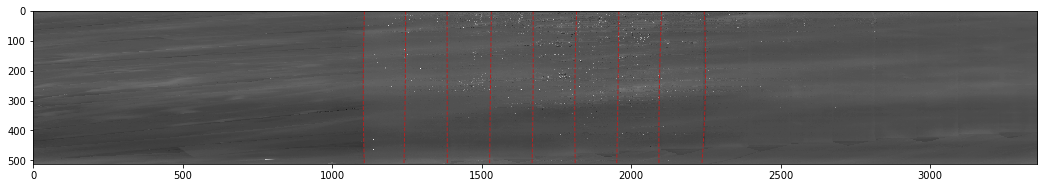

In [26]:
np.set_printoptions(threshold=sys.maxsize)
for folder in folderList:
    batchDir = imgSourceFolders + folder
    for file in os.listdir(batchDir):
        if file.endswith(".png") and not file.startswith("._"):
            print(file)
            filePath = os.path.join(batchDir, file)
            img = cv2.imread(filePath, 0)
            plotImage(img)
            
            edges = tow_detection(img)
            print("The edges shape is", edges.shape)
            
            # plot the edges on the image
            fig=plt.figure(figsize=(18, 16))
            plt.imshow(img, cmap='gray')
            
            for i in range(len(edges)):
                x = edges[i, 0, :]
                y = edges[i, 1, :]
                plt.plot(x, y, '--', linewidth=1, color='firebrick')
            plt.show()
        #break
    break

In [121]:
a = np.array([[21.0, 20.0, 22.0, 24.0, 18.0, 11.0, 23.0],
                [21.0, 20.0, 22.0, 24.0, 18.0, 11.0, 23.0],
                [21.0, 20.0, 25.0, 24.0, 18.0, 11.0, 23.0],
                [21.0, 20.0, 22.0, 99.0, 18.0, 11.0, 23.0],
                [21.0, 20.0, 22.0, 24.0, 18.0, 11.0, 23.0],
                [29.0, 20.0, 22.0, 24.0, 18.0, 11.0, 23.0]])
max_inds = np.argmax(a, axis=1)

print(a[:,max_inds])

[[24. 24. 22. 24. 24. 21.]
 [24. 24. 22. 24. 24. 21.]
 [24. 24. 25. 24. 24. 21.]
 [99. 99. 22. 99. 99. 21.]
 [24. 24. 22. 24. 24. 21.]
 [24. 24. 22. 24. 24. 29.]]
